# ABC calibration of $I_\text{CaL}$ in Courtemanche model to original dataset.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.29.1


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used in the publication:
 - Steady-state activation [Li1997]
 - Steady-state inactivation [Li1997]
 - Inactivation time constant [Sun1997]

In [4]:
from experiments.ical_li import (li_act,
                                 li_inact_1000)
from experiments.ical_sun import sun_inact_kin_slow

In [5]:
modelfile = 'models/courtemanche_ical.mmt'

 Plot steady-state and time constant functions of original model

In [6]:
from ionchannelABC.visualization import plot_variables

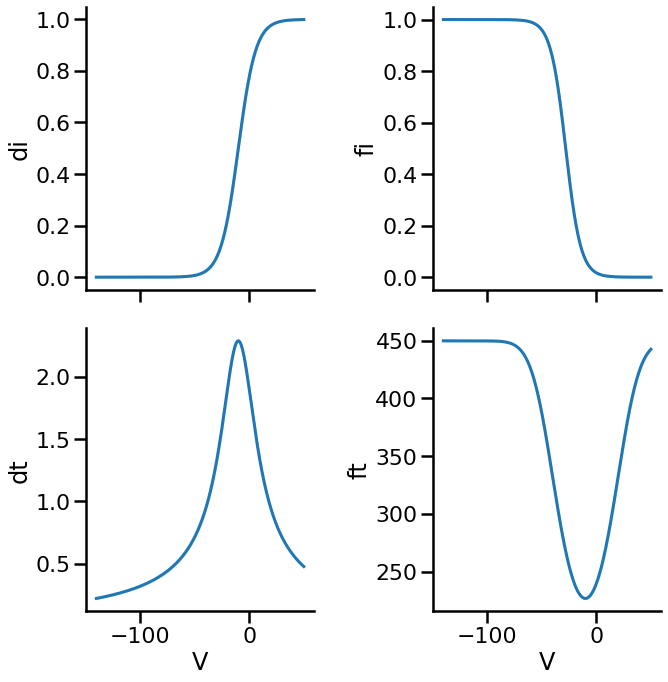

In [7]:
sns.set_context('poster')

V = np.arange(-140, 50, 0.01)

cou_par_map = {'di': 'ical.d_inf',
            'fi': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'ft': 'ical.tau_f'}

f, ax = plot_variables(V, cou_par_map, 'models/courtemanche_ical.mmt', figshape=(2,2))

# Activation gate ($d$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

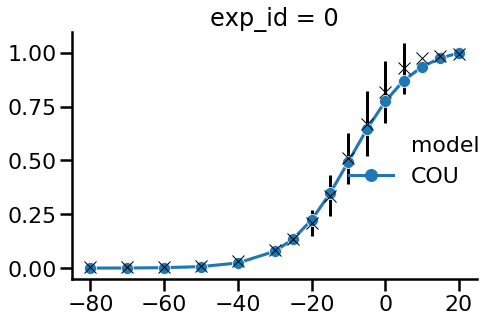

In [10]:
g = plot_sim_results(modelfile,
                     li_act)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [12]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (-100, 100),
          'ical.p5': (0, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [13]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [14]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ical_dgate_original.db"))

In [15]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [16]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32 particles


In [17]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.2446079782705148, '1': 1.2446079782705148, '2': 1.2446079782705148, '3': 1.2446079782705148, '4': 1.2446079782705148, '5': 1.2446079782705148, '6': 1.2446079782705148, '7': 1.042671915141306, '8': 0.6364361040472902, '9': 0.5199531035717904, '10': 0.40923240093228713, '11': 0.42429073603152656, '12': 0.521335957570653, '13': 1.2446079782705148, '14': 1.2446079782705148, '15': 1.2446079782705148}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [18]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [19]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-17 13:46:20.011046, end_time=None)>


In [20]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 2026
DEBUG:Epsilon:new eps, t=1, eps=1.5249660839874908
INFO:ABC:t:1 eps:1.5249660839874908
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 5820
DEBUG:Epsilon:new eps, t=2, eps=0.8672636047163372
INFO:ABC:t:2 eps:0.8672636047163372
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 9851
DEBUG:Epsilon:new eps, t=3, eps=0.6122752469319943
INFO:ABC:t:3 eps:0.6122752469319943
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 14317
DEBUG:Epsilon:new eps, t=4, eps=0.5053136055782594
INFO:ABC:t:4 eps:0.5053136055782594
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 19089
DEBUG:Epsilon:new eps, t=5, eps=0.4381834471

### Analysis of results

In [18]:
df, w = history.get_distribution(m=0)

In [19]:
df.describe()

name,ical.p1,ical.p2,ical.p4,ical.p5,log_ical.p3
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-64.968145,10.380238,17.914814,6.142103,-6.351218
std,15.102658,5.168971,4.096174,0.427570,0.969497
min,-99.203878,0.228430,3.928299,5.615548,-6.807049
25%,-75.280129,6.162337,18.678294,5.916643,-6.730432
50%,-66.906606,10.211761,19.252756,6.037111,-6.696019
75%,-56.688353,14.655124,19.780059,6.182823,-6.648474
max,-19.419167,22.396021,21.104552,8.742910,-2.035612


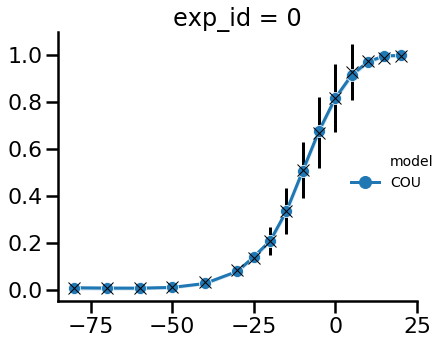

In [20]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     li_act,
                     df=df, w=w)

plt.tight_layout()

In [21]:
import pandas as pd
N = 100
cou_par_samples = df.sample(n=N, weights=w, replace=True)
cou_par_samples = cou_par_samples.set_index([pd.Index(range(N))])
cou_par_samples = cou_par_samples.to_dict(orient='records')

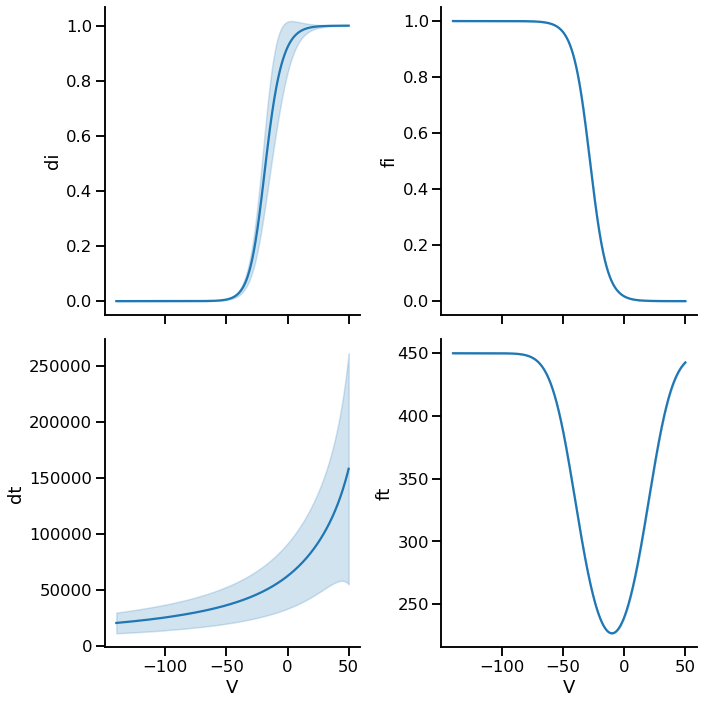

In [22]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_par_map, 
                       'models/courtemanche_ical.mmt', 
                       [cou_par_samples],
                       figshape=(2,2))
plt.tight_layout()

In [23]:
m,_,_ = myokit.load(modelfile)

In [24]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

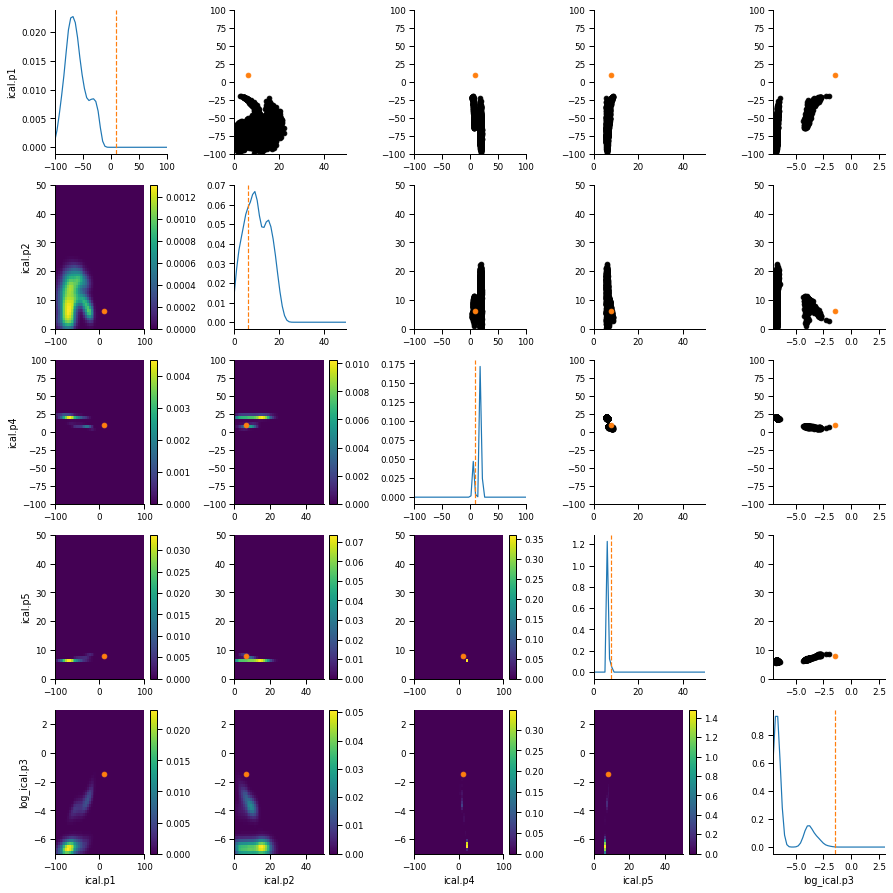

In [25]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()

# Voltage-dependent inactivation gate ($f$) calibration

In [12]:
observations, model, summary_statistics = setup(modelfile,
                                                li_inact_1000,
                                                sun_inact_kin_slow)

In [13]:
assert len(observations)==len(summary_statistics(model({})))

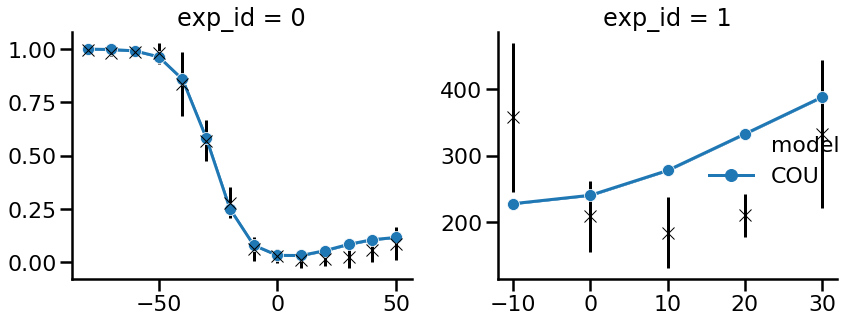

In [14]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     sun_inact_kin_slow)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [15]:
limits = {'log_ical.q1': (0, 3),
          'log_ical.q2': (-2, 3),
          'log_ical.q3': (-4, 0),
          'ical.q4': (-100, 100),
          'log_ical.q5': (-4, 0),
          'ical.q6': (-100, 100),
          'ical.q7': (0, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [16]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [17]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ical_fgate_original.db"))

In [18]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [19]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 128 particles


In [20]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.176132058445145, '1': 1.176132058445145, '2': 1.176132058445145, '3': 1.176132058445145, '4': 0.3892784268190627, '5': 0.604405978482229, '6': 0.8074486118786046, '7': 1.0034312846646722, '8': 1.176132058445145, '9': 1.176132058445145, '10': 1.176132058445145, '11': 1.0995044927708642, '12': 1.0034312846646722, '13': 0.7544045424851181, '14': 0.5263305611568131, '15': 1.104247498336103, '16': 1.1063428446327512, '17': 1.8421569640488558, '18': 0.5260931009442432}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [21]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [22]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-12-19 16:03:48.675367, end_time=None)>


In [23]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 100.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.
DEBUG:ABC:Total samples up to t = 0: 9526.
INFO:ABC:Acceptance rate: 2000 / 9526 = 2.0995e-01.
DEBUG:Epsilon:new eps, t=1, eps=5.410126343117716
INFO:ABC:t: 1, eps: 5.410126343117716.
DEBUG:ABC:Now submitting population 1.
DEBUG:ABC:Population 1 done.
DEBUG:ABC:Total samples up to t = 1: 14688.
INFO:ABC:Acceptance rate: 2000 / 5162 = 3.8745e-01.
DEBUG:Epsilon:new eps, t=2, eps=1.915001114823063
INFO:ABC:t: 2, eps: 1.915001114823063.
DEBUG:ABC:Now submitting population 2.
DEBUG:ABC:Population 2 done.
DEBUG:ABC:Total samples up to t = 2: 20140.
INFO:ABC:Acceptance rate: 2000 / 5452 = 3.6684e-01.
DEBUG:Epsilon:new eps, t=3, eps=1.4518825023650184
INFO:ABC:t: 3, eps: 1.4518825023650184.
DEBUG:ABC:Now submitting population 3.
DEBUG:ABC:Population 3 done.
DEBUG:ABC:Total samples up to t = 3: 27817.
INFO:ABC:Acceptance rate: 2000 / 7677 = 2.6052e-01.
DEBUG:Epsilon:new eps, t=4, eps=1.0862157695273233


### Analysis of results

In [24]:
history = History(db_path)

In [25]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-12-19 16:03:48.675367, end_time=2019-12-19 21:43:23.862005)>]

In [26]:
df, w = history.get_distribution(m=0)

In [27]:
df.describe()

name,ical.q4,ical.q6,ical.q7,log_ical.q1,log_ical.q2,log_ical.q3,log_ical.q5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-7.501727,27.805097,6.864781,1.726074,-0.601147,-2.161639,-1.720660
std,42.169034,1.265677,0.864576,0.658163,0.876593,0.897460,1.037785
min,-99.913440,23.627697,2.795492,0.016095,-1.997376,-3.998965,-3.997194
25%,-30.724446,26.995273,6.378379,1.253584,-1.280465,-2.755195,-2.525602
50%,-11.305228,27.703611,6.852740,1.755407,-0.683686,-2.099668,-1.570363
75%,10.987781,28.441960,7.365816,2.230331,-0.043055,-1.647802,-0.865547
max,99.747909,35.141620,10.189083,2.989503,2.839835,-0.006804,-0.000838


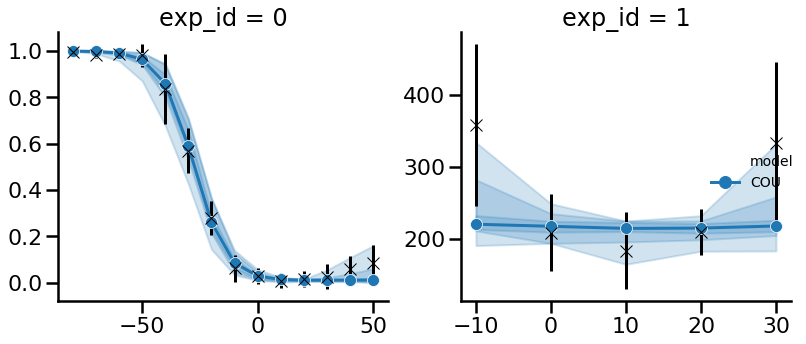

In [28]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     li_inact_1000,
                     sun_inact_kin_slow,
                     df=df, w=w)

plt.tight_layout()

In [29]:
m,_,_ = myokit.load(modelfile)

In [30]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

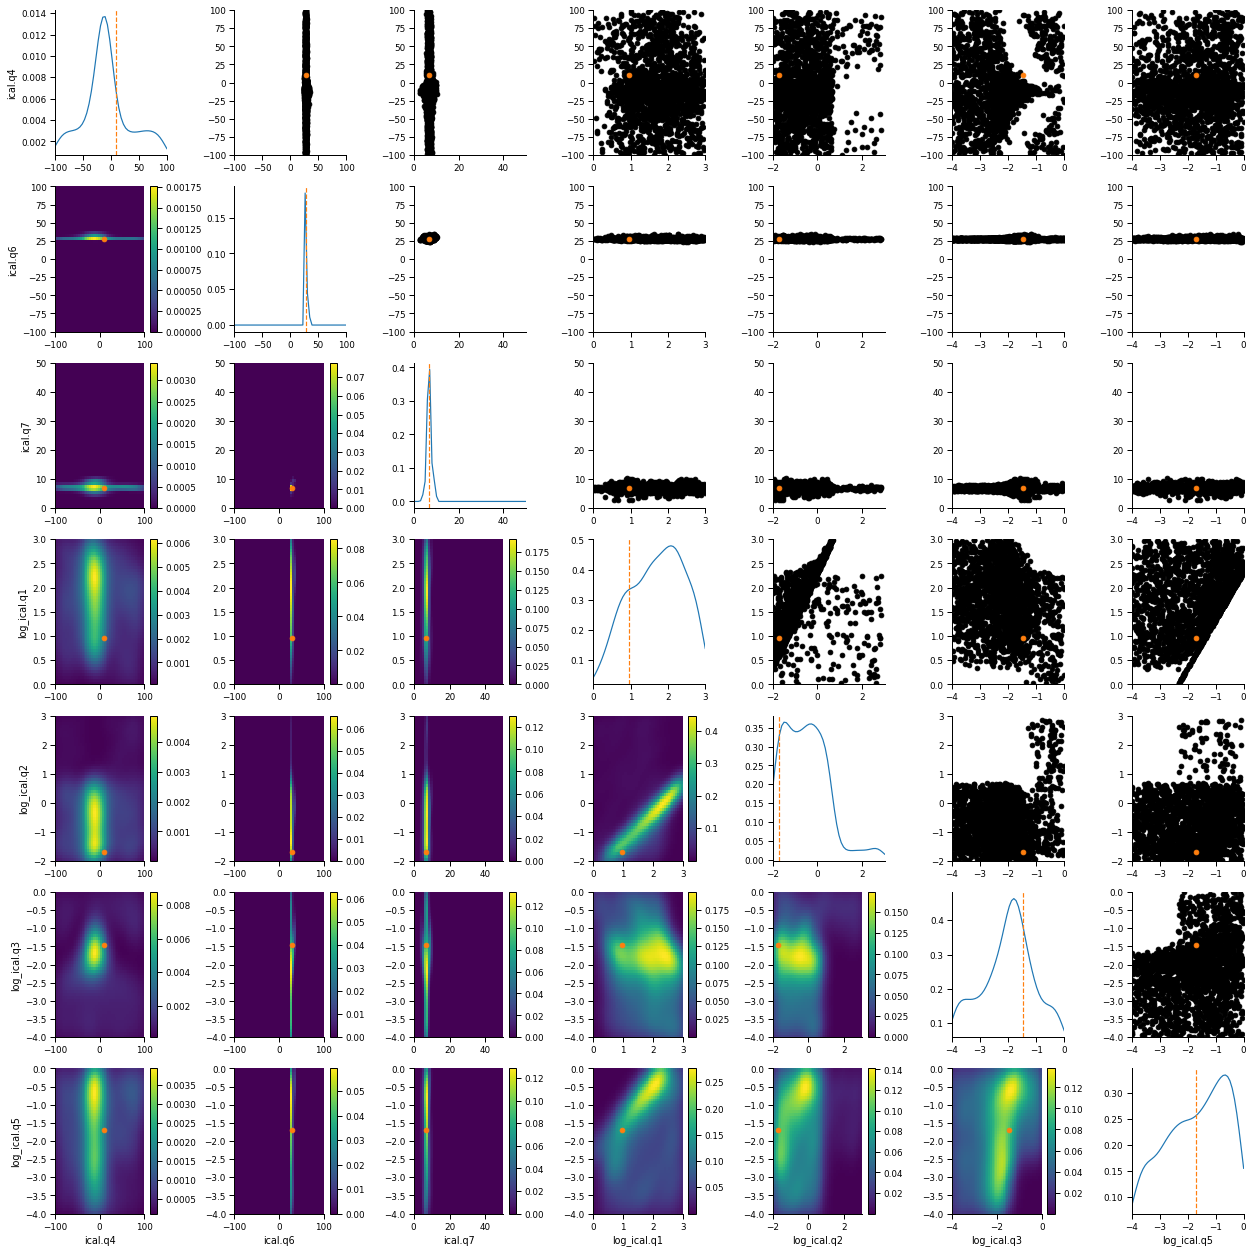

In [31]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()

In [33]:
import pandas as pd
N = 100
cou_par_samples = df.sample(n=N, weights=w, replace=True)
cou_par_samples = cou_par_samples.set_index([pd.Index(range(N))])
cou_par_samples = cou_par_samples.to_dict(orient='records')

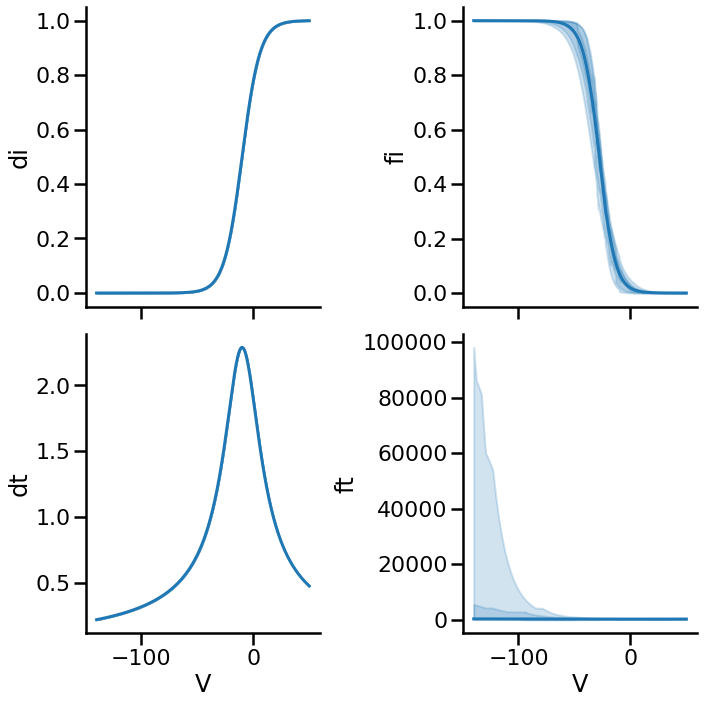

In [34]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_par_map, 
                       'models/courtemanche_ical.mmt', 
                       [cou_par_samples],
                       figshape=(2,2))
plt.tight_layout()